<a href="https://colab.research.google.com/github/TheAmirHK/Portfolio-analysis-and-optimization/blob/main/Portfolio_optimization_via_Pyomo_(Faster_technique).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas_datareader.data as web
import datetime
from datetime import datetime, date, timedelta
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

# For warnings suppression
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install pyomo
from pyomo.environ import *
import matplotlib.pyplot as plt
!wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

In [ ]:
# A function to download stocks' adjusted close price
def receive_data(tickers, start, end):
    adj_close_df = pd.DataFrame()
    for ticker in tickers:
        data = pdr.get_data_yahoo(ticker, start, end, progress=False)
        adj_close_df[ticker] = data["Adj Close"]
    return adj_close_df

In [ ]:
# A function to normalize prices
def daily_return(data):
    log_returns = data.pct_change().dropna()
    return log_returns

In [ ]:
# One portfolio test and evaluation
def evaluation  (data, Rf = 0.02, weights = None):
    result = pd.DataFrame()
    log_return = daily_return(data)
    if weights is None:
        result["ExpRet"] = log_return.mean()*252
        result["ExpVol"] = log_return.std() *np.sqrt(252)
        result["ExpSha"] = (result["ExpRet"] - Rf) / result["ExpVol"]
    else:
        result["ExpRet"] = [np.sum(log_return.mean()*weights)*252]
        result["ExpVol"] = [np.sqrt(weights.T @ log_return.cov() @ weights) * np.sqrt(252)]
        result["ExpSha"] = (result["ExpRet"] - Rf) / result["ExpVol"]
    return result

In [ ]:
# Calculate optimal share volumes using the obtained weights from simulation.
def share_volume(stock_data, results, wealth):
    Optimal_weights = results
    Optimal_weights = np.array(Optimal_weights)
    evaluation = pd.DataFrame()
    evaluation['Price'] = stock_data.iloc[-1]
    evaluation['Optimal Weights'] = Optimal_weights.T
    evaluation['Optimal Volume'] = (evaluation['Optimal Weights'] *wealth / evaluation['Price'])
    evaluation['Optimal Volume'] = evaluation['Optimal Volume'].apply(math.floor)
    evaluation['Total pay'] = evaluation['Optimal Volume'] * evaluation['Price']
    left = wealth - np.sum(evaluation['Total pay'])
    print("Not allocated budegt: %0.2f $ out of %0.2f $"%(left,wealth ))
    return evaluation

In [ ]:
# Compare portfolio performance against market
def portfolio_vs_market(optimization_results, market_data):

    portfolio = optimization_results
    #portfolio = (pd.DataFrame(portfolio)).T

    market_ev = evaluation(market_data)

    df = pd.DataFrame({
    'Portfolio Vs Market': ['ExpRet', 'ExpVol', 'ExpSha'],
    'Portfolio': portfolio.iloc[0].values.tolist(),
    'Market': (market_data.iloc[0]).values.tolist()
    })

    # plotting graph
    df.plot(x="Portfolio Vs Market", y=["Portfolio", "Market"], kind="bar", grid=True)
    plt.show()

    return

In [ ]:
# Eahc individual stocks to be analyzed !
stocks = ["AAPL", "MSFT", "GOOG", "AMZN",   # Technology stocks
          "TSLA", "TM", "MBGYY", "VWAGY", "VLVLY", "GM",  # Motor manufacturing stocks
          "LLY", "JNJ", "AZN"] # Health market stocks
market = ['^GSPC'] # S&P500 index

# define the number of years to be studied
NYears = 5

# Risk-free asset rate
Rf = 0.02

# Wealth value (Budget)
wealth = 5000

# Define the time period of study
end = datetime.today()
start = end - timedelta(days = NYears*365)
print("Start date:%str   End date:%str" %(start, end))

stock_data = receive_data(stocks, start, end)
market_data = receive_data(market, start, end)
log_stock_data = daily_return(stock_data)

Start date:2018-11-27 21:35:01.114120tr   End date:2023-11-26 21:35:01.114120tr


In [ ]:
# Let's optimize the portfolio using pyomo
import pyomo
import math
from pyomo.environ import *

def Input_ExpRet (model, i):
    return log_stock_data.mean()[i]

# create a function to return covariance by index i and j
def get_covariance(model, i, j):
    return (log_stock_data.cov())[i][j]

# create an instance of ConcreteModel
model = ConcreteModel("Portfolio_Optimization")

# create a set of assets
model.i = Set(initialize = stocks, doc = 'List of assets')

# create parameter r_i
model.r = Param(model.i, rule = Input_ExpRet, doc = 'Expected annual return')

# create parameter cov_ij
model.cov = Param(model.i, model.i, rule = get_covariance, doc = 'Covariance')

# create decision variable x_i
model.X = Var(model.i, bounds = (0,1))

# create constraint that sum of all asset ratio = 1
model.C1 = Constraint(expr = sum(model.X[i] for i in model.i) == 1)

# define expected return
Return = sum(model.X[i]*model.r[i] for i in model.i)*252

# define expected voatility
Risk = sqrt(sum([model.X[i]*model.X[j]*model.cov[i,j] for i in model.i for j in model.i]) + 0.000000001)*sqrt(252)

sharp = (Return - 0.025)/ Risk

# define objective function
model.obj = Objective(expr =sharp, sense = maximize)

# call solver to optimize
SolverFactory('ipopt').solve(model) # applicable solvers: bonmin, cbc, ipopt

# display and save optimal weights
model.obj.display()
model.X.display()
optimal_values = [value(model.X[key]) for key in model.X]

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 1.4976040688987786
X : Size=13, Index=i
    Key   : Lower : Value                  : Upper : Fixed : Stale : Domain
     AAPL :     0 :    0.15459247640413015 :     1 : False : False :  Reals
     AMZN :     0 :  7.189558307366743e-08 :     1 : False : False :  Reals
      AZN :     0 : 2.2068122223866712e-07 :     1 : False : False :  Reals
       GM :     0 :  3.384151487373327e-08 :     1 : False : False :  Reals
     GOOG :     0 : 2.1012143368288372e-07 :     1 : False : False :  Reals
      JNJ :     0 :  7.413836339011227e-08 :     1 : False : False :  Reals
      LLY :     0 :     0.6216268390158686 :     1 : False : False :  Reals
    MBGYY :     0 :  8.726401486224969e-08 :     1 : False : False :  Reals
     MSFT :     0 :  6.836019864577052e-07 :     1 : False : False :  Reals
       TM :     0 :  1.946778756614795e-07 :     1 : False : False :  Reals
     TSLA :     0 :    0.223778480956944

In [ ]:
# Calculate the share_volume
share_volume(stock_data, optimal_values, wealth)

Not allocated budegt: 292.82 $ out of 5000.00 $


,Price,Optimal Weights,Optimal Volume,Total pay
AAPL,189.970001,1.545925e-01,4,759.880005
MSFT,377.429993,6.836020e-07,0,0.000000
GOOG,138.220001,2.101214e-07,0,0.000000
AMZN,146.740005,7.189558e-08,0,0.000000
TSLA,235.449997,2.237785e-01,4,941.799988
TM,188.300003,1.946779e-07,0,0.000000
MBGYY,15.980000,8.726401e-08,0,0.000000
VWAGY,12.950000,4.745362e-08,0,0.000000
VLVLY,22.809999,5.799474e-07,0,0.000000
GM,28.180000,3.384151e-08,0,0.000000


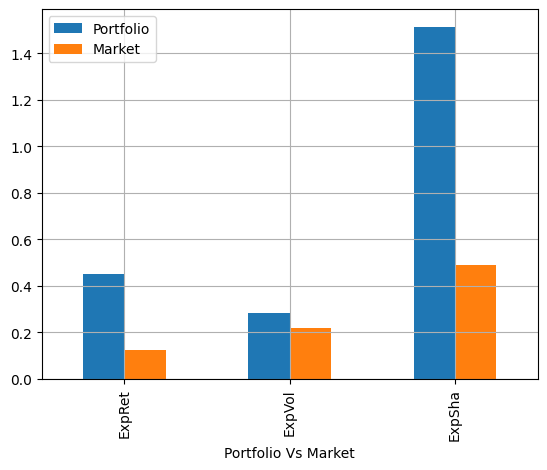

In [ ]:
# Evaluate market and optimal portfolio performances adn compare them
portfolio = evaluation(stock_data, weights = np.asarray(optimal_values) )
market_ev = evaluation(market_data)
portfolio_vs_market(portfolio,market_ev)